In [1]:
!pip install datasets
#!pip install optuna
!pip install scikit-multilearn
!pip install PyEvALL
! pip install --quiet timm

import pandas as pd
import logging
from datasets import Dataset
import os
#import optuna

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import f1_score
from tqdm import tqdm
from PIL import Image
import timm

# Import the drive library
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('drive/MyDrive/Colab/thesis/models')
from utils_classification import *

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [3]:
# Define the multimodal dataset class
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, dir, data_dir, bin_label, tokenizer, max_length, transform=None):
        self.dataframe = dataframe
        self.dir = dir
        self.data_dir = data_dir
        self.bin_label = bin_label
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        #if idx is a batch of indices (which is a list or tensor), process each index
        if isinstance(idx, (list, torch.Tensor)):
            rows = self.dataframe.iloc[idx]  #this returns a df (batch of rows)
        else:
            rows = self.dataframe.iloc[[idx]]  #single index (returns a df with 1 row)

        #initialize lists for processed data
        img_paths = []
        texts = []
        labels = []

        #process each row in the batch
        for _, row in rows.iterrows():  #use iterrows() to access each row in the batch
            img_name = str(row['meme path'])
            img_path = os.path.join(f"{self.dir}/datasets/{self.data_dir}/", img_name)
            text = str(row['meme text']).lower() #lowercase for RoBERTa
            label = row[self.bin_label]

            #append to the lists
            img_paths.append(img_path)
            texts.append(text)
            labels.append(label)

        #process images in the batch
        images = [Image.open(img_path).convert('RGB') for img_path in img_paths]
        if self.transform:
            images = [self.transform(image) for image in images]

        #process text using the tokenizer
        encodings = [self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        ) for text in texts]

        #stack the encoding results
        input_ids = torch.stack([encoding["input_ids"].flatten() for encoding in encodings])
        attention_mask = torch.stack([encoding["attention_mask"].flatten() for encoding in encodings])

        #convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long)

        return {
            "image": torch.stack(images),
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


# Define the multimodal model
class MultimodalClassifier(nn.Module):
    def __init__(self, roberta_model, num_classes, fusion_output_size=512):
        super(MultimodalClassifier, self).__init__()
        self.roberta = roberta_model
        self.swin = timm.create_model('swinv2_base_window8_256', pretrained=True, num_classes=0)

        self.text_projection = nn.Linear(self.roberta.config.hidden_size, fusion_output_size)
        self.image_projection = nn.Linear(self.swin.num_features, fusion_output_size)

        self.fusion_layers = nn.Sequential(
            nn.LayerNorm(fusion_output_size * 2),
            nn.Linear(fusion_output_size * 2, fusion_output_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(fusion_output_size),
            nn.Linear(fusion_output_size, fusion_output_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(fusion_output_size)
        )

        self.classifier = nn.Linear(fusion_output_size, num_classes)

    def forward(self, input_ids, attention_mask, image):
        text_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[1]
        image_outputs = self.swin(image)

        text_projected = self.text_projection(text_outputs)
        image_projected = self.image_projection(image_outputs)

        combined = torch.cat((text_projected, image_projected), dim=1)
        fused = self.fusion_layers(combined)
        outputs = self.classifier(fused)
        return outputs

In [4]:
# Set up training and evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_length = 512
num_classes = 2
batch_size = 16
num_epochs = 10
learning_rate = 1e-5

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dir = "/content/drive/MyDrive/Colab/thesis"

#MAMI: testing on EXIST

## Binary Classification: Misogynous vs. non-misogynous

In [6]:
ds_name = "MAMI"
cross_ds_name = "EXIST2024"
evaluation_type = "binary"
# Load datasets
mami_training_data = "".join([dir, "/data/overlapping_classes/MAMI/MAMI_training.json"])
mami_val_data = "".join([dir,"/data/overlapping_classes/MAMI/MAMI_validation.json"])
exist_test_data = "".join([dir, "/data/overlapping_classes/EXIST2024/EXIST2024_test.json"])
mami_train_df = pd.read_json(mami_training_data,orient='index')
mami_dev_df = pd.read_json(mami_val_data,orient='index')
exist_test_df = pd.read_json(exist_test_data,orient='index')

# Create datasets
data_dir = "MAMI DATASET"
binary_label = "misogynous"
data_dir_cross = "EXIST 2024"
binary_label_cross = "sexist"
train_dataset = MultimodalDataset(mami_train_df, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)
val_dataset = MultimodalDataset(mami_dev_df, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)
test_dataset = MultimodalDataset(exist_test_df, dir, data_dir_cross, binary_label_cross, tokenizer, max_length, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
# Create the model
roberta_model = RobertaModel.from_pretrained("roberta-base")
model = MultimodalClassifier(roberta_model, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

In [ ]:
# Train and validate the model
best_val_f1 = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_true, val_preds, average='macro')
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        save_path = f"{dir}/models/cross_dataset/{ds_name}/{evaluation_type}/multimodal/roberta"
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/best_multimodal_model_misogyny.pth")

Epoch 1/10: 100%|██████████| 74/74 [06:00<00:00,  4.87s/it]


Epoch [1/10], Train Loss: 0.6636, Val F1: 0.6743


Epoch 2/10: 100%|██████████| 74/74 [00:50<00:00,  1.47it/s]


Epoch [2/10], Train Loss: 0.4581, Val F1: 0.7458


Epoch 3/10: 100%|██████████| 74/74 [01:08<00:00,  1.08it/s]


Epoch [3/10], Train Loss: 0.2977, Val F1: 0.8257


Epoch 4/10: 100%|██████████| 74/74 [01:08<00:00,  1.08it/s]


Epoch [4/10], Train Loss: 0.1556, Val F1: 0.8180


Epoch 5/10: 100%|██████████| 74/74 [00:49<00:00,  1.49it/s]


Epoch [5/10], Train Loss: 0.0842, Val F1: 0.8560


Epoch 6/10: 100%|██████████| 74/74 [01:09<00:00,  1.07it/s]


Epoch [6/10], Train Loss: 0.0406, Val F1: 0.8407


Epoch 7/10: 100%|██████████| 74/74 [00:49<00:00,  1.49it/s]


Epoch [7/10], Train Loss: 0.0238, Val F1: 0.8560


Epoch 8/10: 100%|██████████| 74/74 [00:49<00:00,  1.49it/s]


Epoch [8/10], Train Loss: 0.0255, Val F1: 0.8181


Epoch 9/10: 100%|██████████| 74/74 [00:49<00:00,  1.49it/s]


Epoch [9/10], Train Loss: 0.0227, Val F1: 0.8257


Epoch 10/10: 100%|██████████| 74/74 [00:49<00:00,  1.49it/s]


Epoch [10/10], Train Loss: 0.0127, Val F1: 0.8711


In [8]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load(f"{dir}/models/cross_dataset/{ds_name}/{evaluation_type}/multimodal/roberta/best_multimodal_model_misogyny.pth"))
model.eval()
y_pred = []
y_test = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask, images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_test.extend(labels.cpu().numpy())

Testing: 100%|██████████| 10/10 [02:23<00:00, 14.36s/it]


Saved EXIST2024 test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/multimodal_roberta_swin_EXIST2024_test_binary.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/multimodal_roberta_swin_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for Multimodal (RoBERTa + Swin V2) (Cross-Dataset):
              precision    recall  f1-score   support

  non-sexist       0.68      0.58      0.62        76
      sexist       0.63      0.72      0.67        76

    accuracy                           0.65       152
   macro avg       0.65      0.65      0.65       152
weighted avg       0.65      0.65      0.65       152

----------------------------------------------------------------------------------------------------
--------------------------

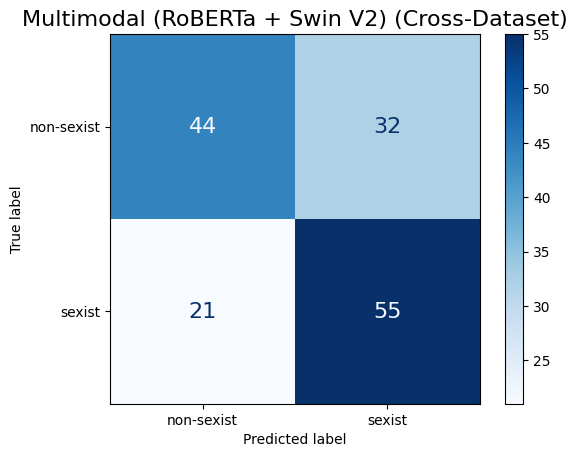

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for Multimodal (RoBERTa + Swin V2) (Cross-Dataset):

2025-06-24 15:24:52,627 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-06-24 15:24:53,746 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 15:24:53,799 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-06-24 15:24:53,801 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 15:24:53,860 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 15:24:53,910 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluati

In [9]:
gold_path_test_binary =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "multimodal_roberta_swin", y_pred , binary_label_cross, [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                               ["non-sexist","sexist"],
                               gold_test_txt,test_pred_txt,
                               model_name="Multimodal (RoBERTa + Swin V2) (Cross-Dataset)")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output","cross_dataset",cross_ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/multimodal_roberta_swin_{cross_ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(exist_test_df, y_pred, [binary_label_cross], output_path)

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/multimodal_roberta_swin_EXIST2024_test_binary.csv


## Multilabel Classification: Misogyny Categorization

Since misogynous was already done, this category won't be fine-tuned again.

In [10]:
ds_name = "MAMI"
cross_ds_name = "EXIST2024"
#load datasets
mami_training_data = "".join([dir, "/data/overlapping_classes/MAMI/MAMI_training.json"])
mami_val_data = "".join([dir,"/data/overlapping_classes/MAMI/MAMI_validation.json"])
exist_test_data = "".join([dir, "/data/overlapping_classes/EXIST2024/EXIST2024_test.json"])
mami_train_df = pd.read_json(mami_training_data,orient='index')
mami_dev_df = pd.read_json(mami_val_data,orient='index')
exist_test_df = pd.read_json(exist_test_data,orient='index')

#image directory
data_dir = "MAMI DATASET"
data_dir_cross = "EXIST 2024"

### Hierarchical predictions after step 1 w/ensemble

In [11]:
evaluation_type = "hierarchical"
binary_label = "misogynous"
train_bin_pos = mami_train_df[mami_train_df[binary_label] == 1] #only the instances with positive class in binary level
dev_positive = mami_dev_df[mami_dev_df[binary_label] == 1]

In [ ]:
fine_grained_labels = ["stereotype","objectification","violence"] #only fine-grained labels

for label in fine_grained_labels:
    print(f"\nTraining model for label: {label.upper()}")

    #prepare datasets for current label
    binary_label = label
    train_dataset = MultimodalDataset(train_bin_pos, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)
    val_dataset = MultimodalDataset(dev_positive, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)

    #DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    #model & loss (binary classification = 2 classes)
    model = MultimodalClassifier(RobertaModel.from_pretrained("roberta-base"), num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    best_val_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"[{label.upper()}] Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        #validation
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                images = batch["image"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask, images)
                _, predicted = torch.max(outputs, 1)

                val_preds.extend(predicted.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_true, val_preds, average='macro')
        print(f"[{label.upper()}] Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            save_path = f"{dir}/models/cross_dataset/{ds_name}/{evaluation_type}/multimodal/roberta"
            os.makedirs(save_path, exist_ok=True)
            torch.save(model.state_dict(), f"{save_path}/best_model_{label}.pth")


Training model for label: STEREOTYPE


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[STEREOTYPE] Epoch 1/10: 100%|██████████| 37/37 [03:31<00:00,  5.72s/it]


[STEREOTYPE] Epoch 1/10, Loss: 0.6566, Val F1: 0.5525


[STEREOTYPE] Epoch 2/10: 100%|██████████| 37/37 [00:27<00:00,  1.37it/s]


[STEREOTYPE] Epoch 2/10, Loss: 0.5263, Val F1: 0.6168


[STEREOTYPE] Epoch 3/10: 100%|██████████| 37/37 [00:42<00:00,  1.15s/it]


[STEREOTYPE] Epoch 3/10, Loss: 0.4280, Val F1: 0.7260


[STEREOTYPE] Epoch 4/10: 100%|██████████| 37/37 [00:41<00:00,  1.12s/it]


[STEREOTYPE] Epoch 4/10, Loss: 0.3181, Val F1: 0.6838


[STEREOTYPE] Epoch 5/10: 100%|██████████| 37/37 [00:30<00:00,  1.20it/s]


[STEREOTYPE] Epoch 5/10, Loss: 0.2169, Val F1: 0.6944


[STEREOTYPE] Epoch 6/10: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


[STEREOTYPE] Epoch 6/10, Loss: 0.1198, Val F1: 0.6772


[STEREOTYPE] Epoch 7/10: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


[STEREOTYPE] Epoch 7/10, Loss: 0.0759, Val F1: 0.6305


[STEREOTYPE] Epoch 8/10: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


[STEREOTYPE] Epoch 8/10, Loss: 0.0412, Val F1: 0.6306


[STEREOTYPE] Epoch 9/10: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


[STEREOTYPE] Epoch 9/10, Loss: 0.0239, Val F1: 0.6038


[STEREOTYPE] Epoch 10/10: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


[STEREOTYPE] Epoch 10/10, Loss: 0.0148, Val F1: 0.5918

Training model for label: OBJECTIFICATION


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[OBJECTIFICATION] Epoch 1/10: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


[OBJECTIFICATION] Epoch 1/10, Loss: 0.6786, Val F1: 0.3832


[OBJECTIFICATION] Epoch 2/10: 100%|██████████| 37/37 [00:24<00:00,  1.49it/s]


[OBJECTIFICATION] Epoch 2/10, Loss: 0.5067, Val F1: 0.4225


[OBJECTIFICATION] Epoch 3/10: 100%|██████████| 37/37 [00:41<00:00,  1.12s/it]


[OBJECTIFICATION] Epoch 3/10, Loss: 0.3826, Val F1: 0.5785


[OBJECTIFICATION] Epoch 4/10: 100%|██████████| 37/37 [00:42<00:00,  1.14s/it]


[OBJECTIFICATION] Epoch 4/10, Loss: 0.3050, Val F1: 0.6071


[OBJECTIFICATION] Epoch 5/10: 100%|██████████| 37/37 [00:41<00:00,  1.13s/it]


[OBJECTIFICATION] Epoch 5/10, Loss: 0.2165, Val F1: 0.6432


[OBJECTIFICATION] Epoch 6/10: 100%|██████████| 37/37 [00:43<00:00,  1.16s/it]


[OBJECTIFICATION] Epoch 6/10, Loss: 0.1281, Val F1: 0.6861


[OBJECTIFICATION] Epoch 7/10: 100%|██████████| 37/37 [00:42<00:00,  1.15s/it]


[OBJECTIFICATION] Epoch 7/10, Loss: 0.0833, Val F1: 0.6964


[OBJECTIFICATION] Epoch 8/10: 100%|██████████| 37/37 [00:42<00:00,  1.15s/it]


[OBJECTIFICATION] Epoch 8/10, Loss: 0.0401, Val F1: 0.6932


[OBJECTIFICATION] Epoch 9/10: 100%|██████████| 37/37 [00:30<00:00,  1.20it/s]


[OBJECTIFICATION] Epoch 9/10, Loss: 0.0242, Val F1: 0.6932


[OBJECTIFICATION] Epoch 10/10: 100%|██████████| 37/37 [00:24<00:00,  1.52it/s]


[OBJECTIFICATION] Epoch 10/10, Loss: 0.0170, Val F1: 0.6907

Training model for label: VIOLENCE


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[VIOLENCE] Epoch 1/10: 100%|██████████| 37/37 [00:24<00:00,  1.49it/s]


[VIOLENCE] Epoch 1/10, Loss: 0.6494, Val F1: 0.4362


[VIOLENCE] Epoch 2/10: 100%|██████████| 37/37 [00:25<00:00,  1.46it/s]


[VIOLENCE] Epoch 2/10, Loss: 0.4994, Val F1: 0.5246


[VIOLENCE] Epoch 3/10: 100%|██████████| 37/37 [00:42<00:00,  1.15s/it]


[VIOLENCE] Epoch 3/10, Loss: 0.3964, Val F1: 0.4870


[VIOLENCE] Epoch 4/10: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


[VIOLENCE] Epoch 4/10, Loss: 0.3018, Val F1: 0.5087


[VIOLENCE] Epoch 5/10: 100%|██████████| 37/37 [00:24<00:00,  1.52it/s]


[VIOLENCE] Epoch 5/10, Loss: 0.2079, Val F1: 0.5568


[VIOLENCE] Epoch 6/10: 100%|██████████| 37/37 [00:42<00:00,  1.16s/it]


[VIOLENCE] Epoch 6/10, Loss: 0.1446, Val F1: 0.6162


[VIOLENCE] Epoch 7/10: 100%|██████████| 37/37 [00:41<00:00,  1.12s/it]


[VIOLENCE] Epoch 7/10, Loss: 0.0773, Val F1: 0.6179


[VIOLENCE] Epoch 8/10: 100%|██████████| 37/37 [00:40<00:00,  1.09s/it]


[VIOLENCE] Epoch 8/10, Loss: 0.0450, Val F1: 0.5875


[VIOLENCE] Epoch 9/10: 100%|██████████| 37/37 [00:30<00:00,  1.22it/s]


[VIOLENCE] Epoch 9/10, Loss: 0.0277, Val F1: 0.6057


[VIOLENCE] Epoch 10/10: 100%|██████████| 37/37 [00:24<00:00,  1.52it/s]


[VIOLENCE] Epoch 10/10, Loss: 0.0186, Val F1: 0.5642


In [12]:
## Evaluation: hierarchical

#load first-level binary predictions
binary_label_cross = "sexist"
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/{cross_ds_name}/ensemble_svm_roberta_robertaswin_{cross_ds_name}_test_binary.csv")
y_pred_binary = binary_preds[f"{binary_label_cross}_prediction"].to_numpy()

In [ ]:
cross_classes = ["stereotyping-dominance","objectification", "sexual-violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = exist_test_df.copy()
test_positive[f"{binary_label_cross}_prediction"] = y_pred_binary
test_positive = test_positive[test_positive[f"{binary_label_cross}_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":exist_test_df["meme id"], f"{binary_label_cross}_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in cross_classes]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#df for results
results_df = pd.DataFrame()

fine_grained_labels = ["stereotype","objectification","violence"]

for in_label,cross_label in zip(fine_grained_labels,cross_classes):

    #prepare datasets for current label
    test_dataset = MultimodalDataset(test_positive, dir, data_dir_cross, cross_label, tokenizer, max_length, transform=transform)

    #DataLoaders
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    #test
    roberta_model = RobertaModel.from_pretrained("roberta-base")
    model = MultimodalClassifier(roberta_model, num_classes).to(device)
    model.load_state_dict(torch.load(f"{dir}/models/cross_dataset/{ds_name}/{evaluation_type}/multimodal/roberta/best_model_{in_label}.pth"))
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Testing {cross_label}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())

    #store predictions
    results_df[cross_label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output","cross_dataset",cross_ds_name,"ensemble_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/multimodal_roberta_swin_{cross_ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"\nPredictions saved to {output_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing stereotyping-dominance: 100%|██████████| 6/6 [00:49<00:00,  8.25s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing objectification: 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing sexual-violence: 1


Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/ensemble_first_step/multimodal_roberta_swin_EXIST2024_test_hierarchical.csv


In [13]:
#compute metrics
exist_label_names = ["sexist","stereotyping-dominance","objectification", "sexual-violence"]
prediction_cols = [f"{label}_prediction" for label in exist_label_names]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/ensemble_first_step/multimodal_roberta_swin_EXIST2024_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file
y_test = exist_test_df[exist_label_names]

/tmp/ipython-input-13-2172259038.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file


In [14]:
evaluation_type = "hierarchical"
gold_path_test =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "multimodal_roberta_swin", y_pred , binary_label_cross, exist_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test,test_pred_json,
                                y_test,y_pred.to_numpy(),
                                exist_label_names,
                                gold_test_txt,test_pred_txt,
                                hierarchy=True)

Saved EXIST2024 test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/multimodal_roberta_swin_EXIST2024_test_hierarchical.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/multimodal_roberta_swin_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                        precision    recall  f1-score   support

            non-sexist       0.70      0.61      0.65        76
stereotyping-dominance       0.33      0.65      0.44        40
       objectification       0.50      0.47      0.48        43
       sexual-violence       0.14      0.12      0.13        16

             micro avg       0.47      0.54      0.50       175
             macro avg       0.42      0.46      0.43       175
          weighted avg       0.51      0.54

In [ ]:
### Hierarchical after Ensemble w/BERT in first step

In [15]:
#load first-level binary predictions
binary_label_cross = "sexist"
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/{cross_ds_name}/ensemble_bert_roberta_robertaswin_{cross_ds_name}_test_binary.csv")
y_pred_binary = binary_preds[f"{binary_label_cross}_prediction"].to_numpy()

In [ ]:
cross_classes = ["stereotyping-dominance","objectification", "sexual-violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = exist_test_df.copy()
test_positive[f"{binary_label_cross}_prediction"] = y_pred_binary
test_positive = test_positive[test_positive[f"{binary_label_cross}_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":exist_test_df["meme id"], f"{binary_label_cross}_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in cross_classes]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#df for results
results_df = pd.DataFrame()

for in_label,cross_label in zip(fine_grained_labels,cross_classes):

    #prepare datasets for current label
    test_dataset = MultimodalDataset(test_positive, dir, data_dir_cross, cross_label, tokenizer, max_length, transform=transform)

    #DataLoaders
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    #test
    roberta_model = RobertaModel.from_pretrained("roberta-base")
    model = MultimodalClassifier(roberta_model, num_classes).to(device)
    model.load_state_dict(torch.load(f"{dir}/models/cross_dataset/{ds_name}/{evaluation_type}/multimodal/roberta/best_model_{in_label}.pth"))
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Testing {cross_label}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())

    #store predictions
    results_df[cross_label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output","cross_dataset",cross_ds_name,"ensemble_w_bert_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/multimodal_roberta_swin_{cross_ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"\nPredictions saved to {output_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-06-24 10:19:08,778 - timm.models._builder - INFO -      load_pretrained() - Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window8_256.ms_in1k)
2025-06-24 10:19:08,849 - timm.models._hub - INFO - load_state_dict_from_hf() - [timm/swinv2_base_window8_256.ms_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Testing stereotyping-dominance: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-06-24 10:19:16,267 - timm.models._builder - INFO -      load_pretrained() - Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window8_256.ms_in1k)
2025-06-24 10:19:16,341 - timm.models._hub - INFO - load_state_dict_from_hf() - [timm/swinv2_base_window8_256.ms_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Testing objectification: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-06-24 10:19:21,594 - timm.models._builder - INFO -      load_pretrained() - Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window8_256.ms_in1k)
2025-06-24 10:19:21,665 - timm.models._hub - INFO - load_state_dict_from_hf() - [timm/swinv2_base_window8_256.ms_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Testing sexual-violence: 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/ensemble_w_bert_first_step/multimodal_roberta_swin_EXIST2024_test_hierarchical.csv


In [16]:
#compute metrics
exist_label_names = ["sexist","stereotyping-dominance","objectification", "sexual-violence"]
prediction_cols = [f"{label}_prediction" for label in exist_label_names]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/ensemble_w_bert_first_step/multimodal_roberta_swin_EXIST2024_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file
y_test = exist_test_df[exist_label_names]

/tmp/ipython-input-16-1304172044.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file


In [17]:
evaluation_type = "hierarchical"
gold_path_test =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "multimodal_roberta_swin", y_pred , binary_label_cross, exist_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test,test_pred_json,
                                y_test,y_pred.to_numpy(),
                                exist_label_names,
                                gold_test_txt,test_pred_txt,
                                hierarchy=True)

Saved EXIST2024 test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/multimodal_roberta_swin_EXIST2024_test_hierarchical.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/multimodal_roberta_swin_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                        precision    recall  f1-score   support

            non-sexist       0.72      0.58      0.64        76
stereotyping-dominance       0.32      0.68      0.44        40
       objectification       0.50      0.51      0.51        43
       sexual-violence       0.15      0.12      0.14        16

             micro avg       0.47      0.54      0.50       175
             macro avg       0.42      0.47      0.43       175
          weighted avg       0.52      0.54

#EXIST: testing on MAMI

## Binary Classification: Sexist vs. non-sexist

In [6]:
ds_name = "EXIST2024"
cross_ds_name = "MAMI"
evaluation_type = "binary"
# Load datasets
exist_training_data = "".join([dir, "/data/overlapping_classes/EXIST2024/EXIST2024_training.json"])
exist_val_data = "".join([dir,"/data/overlapping_classes/EXIST2024/EXIST2024_validation.json"])
mami_test_data = "".join([dir, "/data/overlapping_classes/MAMI/MAMI_test.json"])
exist_train_df = pd.read_json(exist_training_data,orient='index')
exist_dev_df = pd.read_json(exist_val_data,orient='index')
mami_test_df = pd.read_json(mami_test_data,orient='index')

# Create datasets
data_dir = "EXIST 2024"
binary_label = "sexist"
data_dir_cross = "MAMI DATASET"
binary_label_cross = "misogynous"
train_dataset = MultimodalDataset(exist_train_df, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)
val_dataset = MultimodalDataset(exist_dev_df, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)
test_dataset = MultimodalDataset(mami_test_df, dir, data_dir_cross, binary_label_cross, tokenizer, max_length, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
# Create the model
roberta_model = RobertaModel.from_pretrained("roberta-base")
model = MultimodalClassifier(roberta_model, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train and validate the model
best_val_f1 = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_true, val_preds, average='macro')
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        save_path = f"{dir}/models/cross_dataset/{ds_name}/{evaluation_type}/multimodal/roberta"
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/best_multimodal_model_sexism.pth")

Epoch 1/10: 100%|██████████| 79/79 [11:08<00:00,  8.46s/it]


Epoch [1/10], Train Loss: 0.7221, Val F1: 0.5746


Epoch 2/10: 100%|██████████| 79/79 [01:02<00:00,  1.27it/s]


Epoch [2/10], Train Loss: 0.6247, Val F1: 0.6013


Epoch 3/10: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s]


Epoch [3/10], Train Loss: 0.4739, Val F1: 0.7068


Epoch 4/10: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s]


Epoch [4/10], Train Loss: 0.3288, Val F1: 0.6847


Epoch 5/10: 100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch [5/10], Train Loss: 0.2001, Val F1: 0.6893


Epoch 6/10: 100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch [6/10], Train Loss: 0.1062, Val F1: 0.6748


Epoch 7/10: 100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch [7/10], Train Loss: 0.0510, Val F1: 0.6712


Epoch 8/10: 100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch [8/10], Train Loss: 0.0304, Val F1: 0.6925


Epoch 9/10: 100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch [9/10], Train Loss: 0.0667, Val F1: 0.7071


Epoch 10/10: 100%|██████████| 79/79 [01:18<00:00,  1.01it/s]


Epoch [10/10], Train Loss: 0.0269, Val F1: 0.6928


In [8]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load(f"{dir}/models/cross_dataset/{ds_name}/{evaluation_type}/multimodal/roberta/best_multimodal_model_sexism.pth"))
model.eval()
y_pred = []
y_test = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask, images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_test.extend(labels.cpu().numpy())

Testing: 100%|██████████| 61/61 [13:41<00:00, 13.47s/it]


Saved MAMI test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/multimodal_roberta_swin_MAMI_test_binary.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/multimodal_roberta_swin_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for Multimodal (RoBERTa + Swin V2) (Cross-Dataset):
                precision    recall  f1-score   support

non-misogynous       0.74      0.59      0.66       500
    misogynous       0.64      0.78      0.71       476

      accuracy                           0.68       976
     macro avg       0.69      0.69      0.68       976
  weighted avg       0.69      0.68      0.68       976

----------------------------------------------------------------------------------------------------
--------------------------------------------

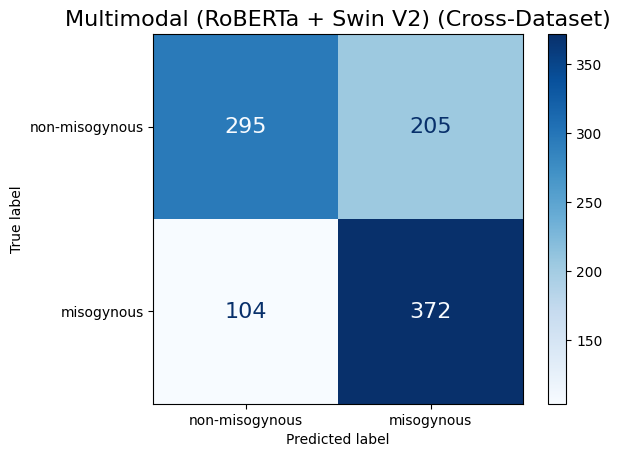

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for Multimodal (RoBERTa + Swin V2) (Cross-Dataset):

2025-06-24 15:40:24,119 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-06-24 15:40:26,531 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 15:40:26,942 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-06-24 15:40:26,945 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 15:40:27,383 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 15:40:27,753 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluati

In [9]:
gold_path_test_binary =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "multimodal_roberta_swin", y_pred , binary_label_cross, [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                                ["non-misogynous","misogynous"],
                               gold_test_txt,test_pred_txt,
                               model_name="Multimodal (RoBERTa + Swin V2) (Cross-Dataset)")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output","cross_dataset",cross_ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/multimodal_roberta_swin_{cross_ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(mami_test_df, y_pred, [binary_label_cross], output_path)

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/multimodal_roberta_swin_MAMI_test_binary.csv


## Multilable Classification: Sexism Categorization

In [10]:
ds_name = "EXIST2024"
cross_ds_name = "MAMI"
#load datasets
exist_training_data = "".join([dir, "/data/overlapping_classes/EXIST2024/EXIST2024_training.json"])
exist_val_data = "".join([dir,"/data/overlapping_classes/EXIST2024/EXIST2024_validation.json"])
mami_test_data = "".join([dir, "/data/overlapping_classes/MAMI/MAMI_test.json"])
exist_train_df = pd.read_json(exist_training_data,orient='index')
exist_dev_df = pd.read_json(exist_val_data,orient='index')
mami_test_df = pd.read_json(mami_test_data,orient='index')

#image directory
data_dir = "EXIST 2024"
data_dir_cross = "MAMI DATASET"

### Hierarchical predictions after step 1 w/ensemble

In [11]:
evaluation_type = "hierarchical"
binary_label = "sexist"
train_bin_pos = exist_train_df[exist_train_df[binary_label] == 1] #only the instances with positive class in binary level
dev_positive = exist_dev_df[exist_dev_df[binary_label] == 1]

In [ ]:
fine_grained_labels = ["stereotyping-dominance","objectification", "sexual-violence"] #only fine-grained labels

for label in fine_grained_labels:
    print(f"\nTraining model for label: {label.upper()}")

    #prepare datasets for current label
    binary_label = label
    train_dataset = MultimodalDataset(train_bin_pos, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)
    val_dataset = MultimodalDataset(dev_positive, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)

    #DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    #model & loss (binary classification = 2 classes)
    model = MultimodalClassifier(RobertaModel.from_pretrained("roberta-base"), num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    best_val_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"[{label.upper()}] Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        #validation
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                images = batch["image"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask, images)
                _, predicted = torch.max(outputs, 1)

                val_preds.extend(predicted.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_true, val_preds, average='macro')
        print(f"[{label.upper()}] Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            save_path = f"{dir}/models/cross_dataset/{ds_name}/{evaluation_type}/multimodal/roberta"
            os.makedirs(save_path, exist_ok=True)
            torch.save(model.state_dict(), f"{save_path}/best_model_{label}.pth")



Training model for label: STEREOTYPING-DOMINANCE


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[STEREOTYPING-DOMINANCE] Epoch 1/10: 100%|██████████| 42/42 [03:28<00:00,  4.97s/it]


[STEREOTYPING-DOMINANCE] Epoch 1/10, Loss: 0.7148, Val F1: 0.3619


[STEREOTYPING-DOMINANCE] Epoch 2/10: 100%|██████████| 42/42 [00:33<00:00,  1.26it/s]


[STEREOTYPING-DOMINANCE] Epoch 2/10, Loss: 0.5662, Val F1: 0.4683


[STEREOTYPING-DOMINANCE] Epoch 3/10: 100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


[STEREOTYPING-DOMINANCE] Epoch 3/10, Loss: 0.4511, Val F1: 0.5011


[STEREOTYPING-DOMINANCE] Epoch 4/10: 100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


[STEREOTYPING-DOMINANCE] Epoch 4/10, Loss: 0.3620, Val F1: 0.5035


[STEREOTYPING-DOMINANCE] Epoch 5/10: 100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


[STEREOTYPING-DOMINANCE] Epoch 5/10, Loss: 0.2616, Val F1: 0.5013


[STEREOTYPING-DOMINANCE] Epoch 6/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[STEREOTYPING-DOMINANCE] Epoch 6/10, Loss: 0.1513, Val F1: 0.4814


[STEREOTYPING-DOMINANCE] Epoch 7/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[STEREOTYPING-DOMINANCE] Epoch 7/10, Loss: 0.0811, Val F1: 0.4451


[STEREOTYPING-DOMINANCE] Epoch 8/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[STEREOTYPING-DOMINANCE] Epoch 8/10, Loss: 0.0649, Val F1: 0.4798


[STEREOTYPING-DOMINANCE] Epoch 9/10: 100%|██████████| 42/42 [00:30<00:00,  1.37it/s]


[STEREOTYPING-DOMINANCE] Epoch 9/10, Loss: 0.0331, Val F1: 0.4586


[STEREOTYPING-DOMINANCE] Epoch 10/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[STEREOTYPING-DOMINANCE] Epoch 10/10, Loss: 0.0192, Val F1: 0.4654

Training model for label: OBJECTIFICATION


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[OBJECTIFICATION] Epoch 1/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[OBJECTIFICATION] Epoch 1/10, Loss: 0.7270, Val F1: 0.4911


[OBJECTIFICATION] Epoch 2/10: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]


[OBJECTIFICATION] Epoch 2/10, Loss: 0.5912, Val F1: 0.4603


[OBJECTIFICATION] Epoch 3/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[OBJECTIFICATION] Epoch 3/10, Loss: 0.4863, Val F1: 0.4897


[OBJECTIFICATION] Epoch 4/10: 100%|██████████| 42/42 [00:30<00:00,  1.37it/s]


[OBJECTIFICATION] Epoch 4/10, Loss: 0.4029, Val F1: 0.4921


[OBJECTIFICATION] Epoch 5/10: 100%|██████████| 42/42 [00:48<00:00,  1.15s/it]


[OBJECTIFICATION] Epoch 5/10, Loss: 0.2938, Val F1: 0.5968


[OBJECTIFICATION] Epoch 6/10: 100%|██████████| 42/42 [00:54<00:00,  1.31s/it]


[OBJECTIFICATION] Epoch 6/10, Loss: 0.1900, Val F1: 0.6564


[OBJECTIFICATION] Epoch 7/10: 100%|██████████| 42/42 [00:33<00:00,  1.27it/s]


[OBJECTIFICATION] Epoch 7/10, Loss: 0.1539, Val F1: 0.6489


[OBJECTIFICATION] Epoch 8/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[OBJECTIFICATION] Epoch 8/10, Loss: 0.0750, Val F1: 0.6564


[OBJECTIFICATION] Epoch 9/10: 100%|██████████| 42/42 [00:30<00:00,  1.37it/s]


[OBJECTIFICATION] Epoch 9/10, Loss: 0.0423, Val F1: 0.6998


[OBJECTIFICATION] Epoch 10/10: 100%|██████████| 42/42 [00:48<00:00,  1.14s/it]


[OBJECTIFICATION] Epoch 10/10, Loss: 0.0260, Val F1: 0.7284

Training model for label: SEXUAL-VIOLENCE


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[SEXUAL-VIOLENCE] Epoch 1/10: 100%|██████████| 42/42 [00:48<00:00,  1.15s/it]


[SEXUAL-VIOLENCE] Epoch 1/10, Loss: 0.6220, Val F1: 0.4417


[SEXUAL-VIOLENCE] Epoch 2/10: 100%|██████████| 42/42 [00:33<00:00,  1.26it/s]


[SEXUAL-VIOLENCE] Epoch 2/10, Loss: 0.4843, Val F1: 0.4202


[SEXUAL-VIOLENCE] Epoch 3/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[SEXUAL-VIOLENCE] Epoch 3/10, Loss: 0.3983, Val F1: 0.4417


[SEXUAL-VIOLENCE] Epoch 4/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[SEXUAL-VIOLENCE] Epoch 4/10, Loss: 0.2988, Val F1: 0.5034


[SEXUAL-VIOLENCE] Epoch 5/10: 100%|██████████| 42/42 [00:48<00:00,  1.14s/it]


[SEXUAL-VIOLENCE] Epoch 5/10, Loss: 0.2068, Val F1: 0.5228


[SEXUAL-VIOLENCE] Epoch 6/10: 100%|██████████| 42/42 [00:48<00:00,  1.15s/it]


[SEXUAL-VIOLENCE] Epoch 6/10, Loss: 0.1178, Val F1: 0.6826


[SEXUAL-VIOLENCE] Epoch 7/10: 100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


[SEXUAL-VIOLENCE] Epoch 7/10, Loss: 0.0646, Val F1: 0.6926


[SEXUAL-VIOLENCE] Epoch 8/10: 100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


[SEXUAL-VIOLENCE] Epoch 8/10, Loss: 0.0390, Val F1: 0.7100


[SEXUAL-VIOLENCE] Epoch 9/10: 100%|██████████| 42/42 [00:49<00:00,  1.18s/it]


[SEXUAL-VIOLENCE] Epoch 9/10, Loss: 0.0252, Val F1: 0.6490


[SEXUAL-VIOLENCE] Epoch 10/10: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


[SEXUAL-VIOLENCE] Epoch 10/10, Loss: 0.0225, Val F1: 0.6559


In [12]:
## Evaluation: hierarchical

#load first-level binary predictions
binary_label_cross = "misogynous"
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/{cross_ds_name}/ensemble_svm_roberta_robertaswin_{cross_ds_name}_test_binary.csv")
y_pred_binary = binary_preds[f"{binary_label_cross}_prediction"].to_numpy()

In [ ]:
cross_classes = ["stereotype","objectification", "violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = mami_test_df.copy()
test_positive[f"{binary_label_cross}_prediction"] = y_pred_binary
test_positive = test_positive[test_positive[f"{binary_label_cross}_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":mami_test_df["meme id"], f"{binary_label_cross}_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in cross_classes]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#df for results
results_df = pd.DataFrame()

fine_grained_labels = ["stereotyping-dominance","objectification", "sexual-violence"]

for in_label,cross_label in zip(fine_grained_labels,cross_classes):

    #prepare datasets for current label
    test_dataset = MultimodalDataset(test_positive, dir, data_dir_cross, cross_label, tokenizer, max_length, transform=transform)

    #DataLoaders
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    #test
    roberta_model = RobertaModel.from_pretrained("roberta-base")
    model = MultimodalClassifier(roberta_model, num_classes).to(device)
    model.load_state_dict(torch.load(f"{dir}/models/in_domain/{ds_name}/{evaluation_type}/multimodal/roberta/best_model_{in_label}.pth"))
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Testing {cross_label}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())

    #store predictions
    results_df[cross_label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output","cross_dataset",cross_ds_name,"ensemble_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/multimodal_roberta_swin_{cross_ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing stereotype: 100%|██████████| 35/35 [02:52<00:00,  4.93s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing objectification: 100%|██████████| 35/35 [00:11<00:00,  3.00it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing violence: 100%|██████████|

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/ensemble_first_step/multimodal_roberta_swin_MAMI_test_hierarchical.csv


In [13]:
#compute metrics
mami_label_names = ["misogynous","stereotype","objectification", "violence"]
prediction_cols = [f"{label}_prediction" for label in mami_label_names]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/ensemble_first_step/multimodal_roberta_swin_MAMI_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file
y_test = mami_test_df[mami_label_names]

/tmp/ipython-input-13-4133401870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file


In [14]:
evaluation_type = "hierarchical"
gold_path_test =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "multimodal_roberta_swin", y_pred , binary_label_cross, mami_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test,test_pred_json,
                                y_test,y_pred.to_numpy(),
                                mami_label_names,
                                gold_test_txt,test_pred_txt,
                                hierarchy=True)

Saved MAMI test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/multimodal_roberta_swin_MAMI_test_hierarchical.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/multimodal_roberta_swin_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

 non-misogynous       0.73      0.61      0.67       500
     stereotype       0.52      0.58      0.55       350
objectification       0.56      0.54      0.55       348
       violence       0.25      0.19      0.21       153

      micro avg       0.58      0.54      0.56      1351
      macro avg       0.52      0.48      0.50      1351
   weighted avg       0.58      0.54      0.56      1351
    samples avg       0.59      0.56      0.56      1351

-------

In [ ]:
### Hierarchical after Ensemble w/BERT in first step

In [15]:
#load first-level binary predictions
binary_label_cross = "misogynous"
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/{cross_ds_name}/ensemble_bert_roberta_robertaswin_{cross_ds_name}_test_binary.csv")
y_pred_binary = binary_preds[f"{binary_label_cross}_prediction"].to_numpy()

In [ ]:
cross_classes = ["stereotype","objectification", "violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = mami_test_df.copy()
test_positive[f"{binary_label_cross}_prediction"] = y_pred_binary
test_positive = test_positive[test_positive[f"{binary_label_cross}_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":mami_test_df["meme id"], f"{binary_label_cross}_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in cross_classes]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#df for results
results_df = pd.DataFrame()

fine_grained_labels = ["stereotyping-dominance","objectification", "sexual-violence"]

for in_label,cross_label in zip(fine_grained_labels,cross_classes):

    #prepare datasets for current label
    test_dataset = MultimodalDataset(test_positive, dir, data_dir_cross, cross_label, tokenizer, max_length, transform=transform)

    #DataLoaders
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    #test
    roberta_model = RobertaModel.from_pretrained("roberta-base")
    model = MultimodalClassifier(roberta_model, num_classes).to(device)
    model.load_state_dict(torch.load(f"{dir}/models/in_domain/{ds_name}/{evaluation_type}/multimodal/roberta/best_model_{in_label}.pth"))
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Testing {cross_label}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())

    #store predictions
    results_df[cross_label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output","cross_dataset",cross_ds_name,"ensemble_w_bert_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/multimodal_roberta_swin_{cross_ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-06-24 10:26:09,961 - timm.models._builder - INFO -      load_pretrained() - Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window8_256.ms_in1k)
2025-06-24 10:26:10,007 - timm.models._hub - INFO - load_state_dict_from_hf() - [timm/swinv2_base_window8_256.ms_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Testing stereotype: 100%|██████████| 35/35 [00:26<00:00,  1.32it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-06-24 10:26:39,394 - timm.models._builder - INFO -      load_pretrained() - Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window8_256.ms_in1k)
2025-06-24 10:26:39,434 - timm.models._hub - INFO - load_state_dict_from_hf() - [timm/swinv2_base_window8_256.ms_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Testing objectification: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-06-24 10:26:53,063 - timm.models._builder - INFO -      load_pretrained() - Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window8_256.ms_in1k)
2025-06-24 10:26:53,109 - timm.models._hub - INFO - load_state_dict_from_hf() - [timm/swinv2_base_window8_256.ms_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Testing violence: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/ensemble_w_bert_first_step/multimodal_roberta_swin_MAMI_test_hierarchical.csv


In [16]:
#compute metrics
mami_label_names = ["misogynous","stereotype","objectification", "violence"]
prediction_cols = [f"{label}_prediction" for label in mami_label_names]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/ensemble_w_bert_first_step/multimodal_roberta_swin_MAMI_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file
y_test = mami_test_df[mami_label_names]

/tmp/ipython-input-16-865804503.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file


In [17]:
evaluation_type = "hierarchical"
gold_path_test =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "multimodal_roberta_swin", y_pred , binary_label_cross, mami_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test,test_pred_json,
                                y_test,y_pred.to_numpy(),
                                mami_label_names,
                                gold_test_txt,test_pred_txt,
                                hierarchy=True)

Saved MAMI test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/multimodal_roberta_swin_MAMI_test_hierarchical.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/multimodal_roberta_swin_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

 non-misogynous       0.75      0.63      0.68       500
     stereotype       0.52      0.58      0.55       350
objectification       0.58      0.55      0.57       348
       violence       0.25      0.20      0.22       153

      micro avg       0.59      0.55      0.57      1351
      macro avg       0.52      0.49      0.50      1351
   weighted avg       0.59      0.55      0.57      1351
    samples avg       0.60      0.57      0.57      1351

-------